In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline, Pipeline # combining classifier steps
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
# scaling features, binary encoding, one hot encoding, feature encoding, make PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from scipy.stats.distributions import uniform, loguniform
import itertools
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.base import clone

In [37]:
delimiter = ','
with open("data_cron.csv") as infile:
    input_data = infile.read().replace('\n',',').split(delimiter)

    
df = pd.DataFrame({
        "date": input_data[1::10],
        "dB": input_data[3::10],
        "something": input_data[4::10],
        "ping": input_data[6::10],
        "upload": input_data[7::10],
        "download": input_data[8::10],
        "jitter" : input_data[9::10]
    })
df

,date,dB,something,ping,upload,download,jitter
0,Tue Oct 11 12:30:01 BST 2022,-29.9,12.7,705.18,9.07,37.55,37.55
1,Tue Oct 11 12:35:01 BST 2022,-29.6,12.9,683.09,6.88,37.11,37.11
2,Tue Oct 11 12:40:01 BST 2022,-29.7,12.8,707.55,7.51,38.15,38.15
3,Tue Oct 11 12:45:01 BST 2022,-29.7,12.7,694.09,12.67,38.09,38.09
4,Tue Oct 11 12:50:01 BST 2022,-29.8,12.8,698.18,14.34,38.19,38.19
...,...,...,...,...,...,...,...
1615,Mon Oct 17 07:55:01 BST 2022,-30.9,12.4,741.45,45.23,36.87,6.97
1616,Mon Oct 17 08:00:02 BST 2022,-30.9,12.3,708,7.13,35.48,6.68
1617,Mon Oct 17 08:05:01 BST 2022,-30.8,12.8,712.82,12.18,32.91,6.85
1618,Mon Oct 17 08:10:01 BST 2022,-30.8,12.5,713.73,14.85,33.43,6.87


In [38]:
df.jitter=df.jitter.astype('float64')
df.download=df.download.astype('float64')
df.upload=df.upload.astype('float64')
df.ping=df.ping.astype('float64')
df.something=df.something.astype('float64')
df.dB=df.dB.astype('float64')
df.date = df.date.astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1620 non-null   datetime64[ns]
 1   dB         1620 non-null   float64       
 2   something  1620 non-null   float64       
 3   ping       1620 non-null   float64       
 4   upload     1620 non-null   float64       
 5   download   1620 non-null   float64       
 6   jitter     1620 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 88.7 KB


/usr/local/lib/python3.8/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname BST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


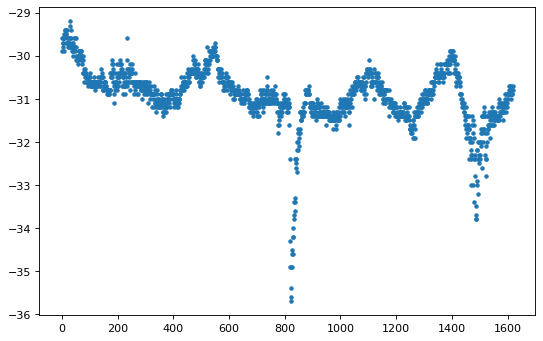

In [54]:
plt.scatter(range(0,1620),df.dB,marker='.')

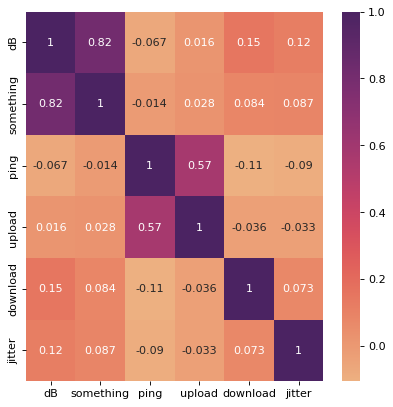

In [39]:
correlation = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation, annot=True, cmap='flare')
plt.show()

In [5]:
df.to_csv('clean_data.csv')

In [6]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse
def tidy_scores(score_dict):
  '''
This function takes the dictionary of scores from the output of the cross_validate funtion
and outputs a neatened dataframe with the training RMSE and testing RMSE for each fold.
The mean and SD of the folds is also calculated and displayed in the dataframe returned.

  '''
  df = pd.DataFrame(score_dict)
  df['test_score'] = -df['test_score']              # Want RMSE rather than -RMSE
  df['train_score'] = -df['train_score']
  df.rename({"test_score":"Test RMSE"}, axis=1, inplace=True)    # Change column names
  df.rename({"train_score":"Train RMSE"}, axis=1, inplace=True)
  df.loc['mean'] = df.mean()     # Take mean of all fold scores
  df.loc['sd'] = df.std()        # Find SD of all fold scores
  df.index.name = "Fold"
  df.drop(['fit_time','score_time'],axis=1,inplace=True)   # Remove irellevant columns

  return df.round(2)          # Round outputted values

In [40]:
df = df.drop(['date'],axis=1)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
# reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# seperate features from output variable
y_train = train_df['dB']
X_train = train_df.drop('dB', axis=1)

y_test = test_df['dB']
X_test = test_df.drop('dB', axis=1)

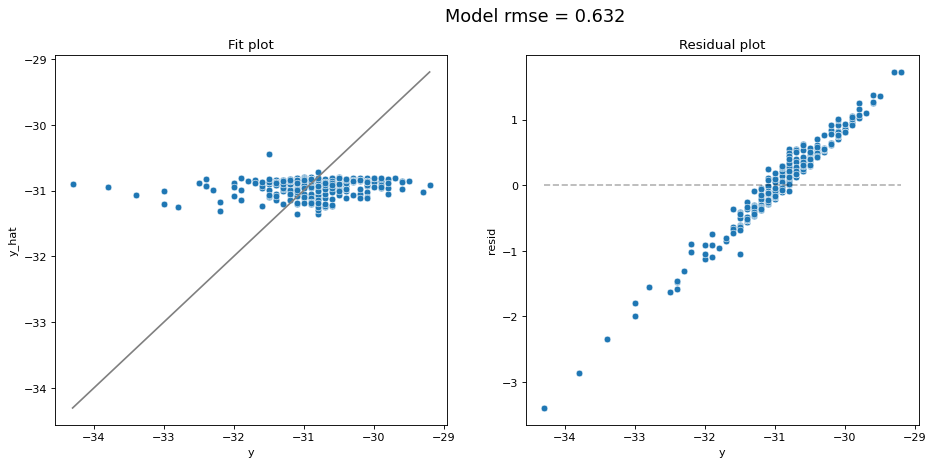

,Test RMSE,Train RMSE
Fold,,
0,0.87,0.64
1,0.43,0.69
2,0.31,0.69
3,0.61,0.67
4,0.29,0.69
5,1.34,0.54
6,0.40,0.69
7,0.48,0.68
8,0.55,0.68


In [8]:
# perform ridge regression
ridge = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10)
)

model = ridge.fit(X_train, y_train)

model_fit(model, X_test, y_test, plot=True)
scores = cross_validate(ridge, df.drop('dB',axis=1), df.dB, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

In [9]:
# searching for the best alpha
alphas = np.linspace(1,200, num=200)
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(10, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

{'ridge__alpha': 195.0}


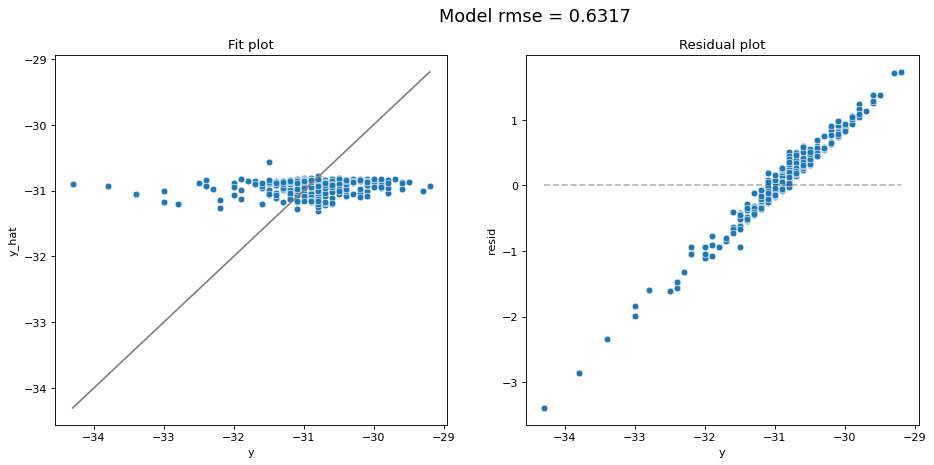

,Test RMSE,Train RMSE
Fold,,
0,0.88,0.64
1,0.43,0.69
2,0.31,0.69
3,0.61,0.67
4,0.28,0.69
5,1.35,0.54
6,0.40,0.69
7,0.47,0.68
8,0.55,0.68


In [10]:
print(gs.best_params_) # best alpha
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

scores = cross_validate(gs.best_estimator_,df.drop('dB',axis=1), df.dB, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

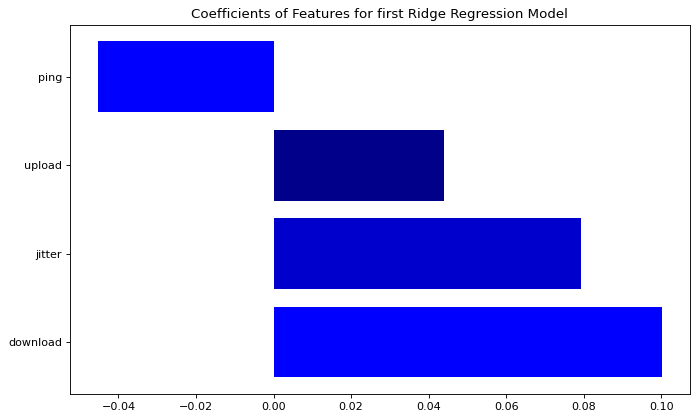

In [11]:
beta = get_coefs(model)
beta_df = pd.DataFrame(np.column_stack((df.drop('dB',axis=1).columns, beta[1:])))
beta_df.columns = ['Feature','Beta']
beta_df = beta_df.sort_values(by=['Beta'], axis = 0 , ascending=False)

plt.figure(figsize=(10,6))
c = ['blue', 'mediumblue', 'darkblue']
plt.barh(beta_df['Feature'],beta_df['Beta'], color=c)
plt.title('Coefficients of Features for first Ridge Regression Model')
plt.show()

## Polynomial Regression

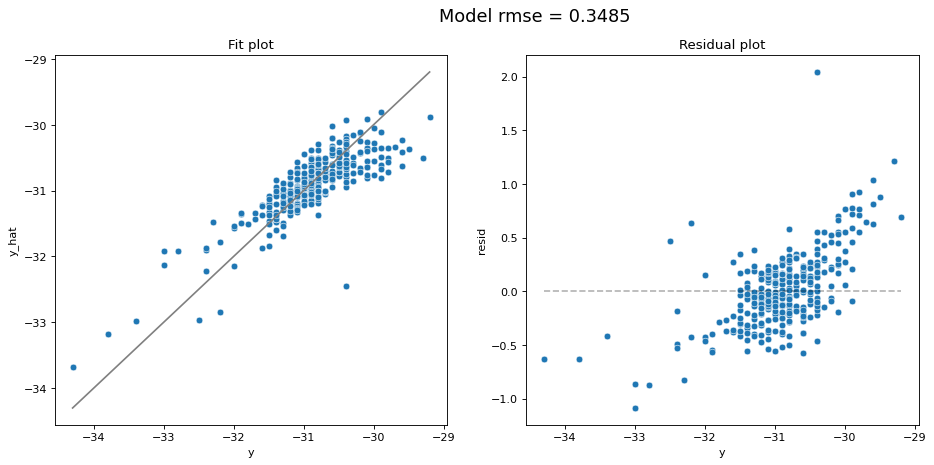

,Test RMSE,Train RMSE
Fold,,
0,0.62,0.35
1,0.49,0.35
2,0.29,0.38
3,0.50,0.35
4,0.33,0.37
5,1.18,0.34
6,0.26,0.38
7,0.43,0.36
8,0.27,0.38


In [41]:
poly = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    Ridge(alpha=10)
)


model = poly.fit(X_train, y_train)

model_fit(model, X_test, y_test, plot=True)
scores = cross_validate(poly, df.drop('dB',axis=1), df.dB, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

In [47]:
# searching for the best alpha
alphas = np.linspace(1,200, num=200)
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=1),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(10, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

{'ridge__alpha': 1.0}


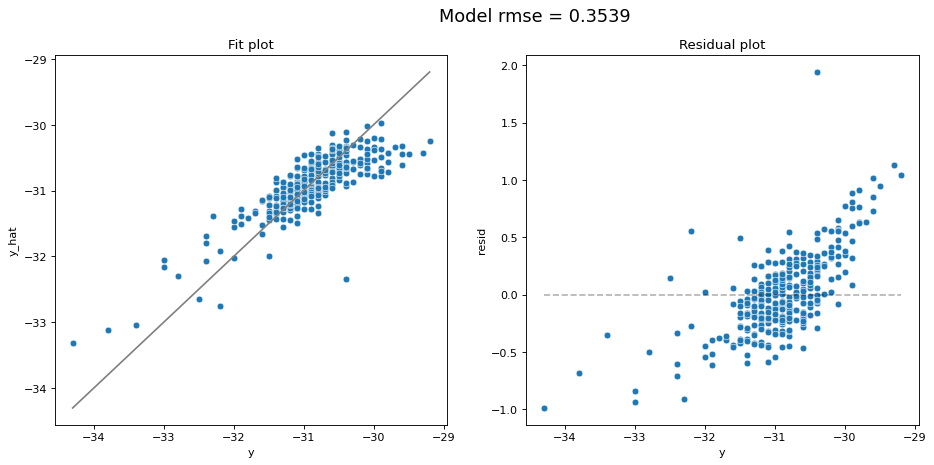

,Test RMSE,Train RMSE
Fold,,
0,0.60,0.36
1,0.50,0.37
2,0.31,0.39
3,0.53,0.37
4,0.32,0.39
5,0.40,0.39
6,0.27,0.40
7,0.44,0.38
8,0.28,0.39


In [48]:
print(gs.best_params_) # best alpha
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

scores = cross_validate(gs.best_estimator_,df.drop('dB',axis=1), df.dB, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

### Issues and Improvements
1. Data has time gaps in it, choose one way to deal with it.
2. Maybe look at time intervals next. Take average dB over an hour to get 24 hrs per day
3. ARIMA
4. Bit more data could be useful. Maybe run data_collect for two weeks
5. Add weather data somehow